# Training a CNN using Backpropagation
The following code implements a variant of the popular convolutional neural network LeNet-5 using low-level libraries on the MNIST dataset. 

## 1 Data Loading
The dataset contains images of 60,000 handwritten digits for training and 10,000 for testing.

In [1]:
# Importing libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2023-08-07 10:16:48.007478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 10:16:48.078129: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 10:16:48.079535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 10:16:49.512125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Printing shapes
print("Shape of x_train:",x_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [4]:
x_train = x_train.reshape((60000,28,28,1))
y_train = y_train.reshape((60000,1))
x_test = x_test.reshape((10000,28,28,1))
y_test = y_test.reshape((10000,1))

Label: [4]


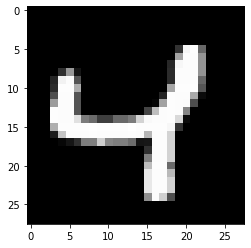

In [5]:
i = np.random.randint(0,60000)
print("Label:",y_train[i])
plt.imshow(x_train[i,:,:],cmap='gray')

## 2 Training a CNN using Backpropagation

In [6]:
# Importing libraries
